In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy import table

from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.wcs import WCS

from astroquery.vizier import Vizier
from astroquery.svo_fps import SvoFps

import photutils

import tqdm

from spectral_cube import SpectralCube
import os
import glob

# load up ALMA-IMF metadata
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis/')
from spectralindex import prefixes
import spitzer_plots
from spitzer_plots import show_fov_on_spitzer, contour_levels, get_spitzer_data

from sedfitter.filter import Filter
from sedfitter.extinction import Extinction
from sedfitter.source import Source
from sedfitter import fit, Fitter

from dust_extinction.parameter_averages import F19

%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['font.size'] = 16

In [2]:
geometries = ["s---s-i", "sp--s-i", "sp--h-i", "s---smi", "sp--smi", "sp--hmi", "s-p-smi", 
              "s-p-hmi", "s-pbsmi", "s-pbhmi", "s-u-smi", "s-u-hmi", "s-ubsmi", "s-ubhmi", 
              "spu-smi", "spu-hmi", "spubsmi", "spubhmi"] 

In [3]:
spicy_row_numbers = pd.read_csv('/blue/adamginsburg/morganhimes/spicy_rownumbers.txt', delimiter=' ')
print(spicy_row_numbers)

    SPICYID  ROWNUM ALMA_1mm ALMA_3mm
0     73642      82        F        F
1     73650      43        T        F
2     73653      83        F        T
3     73659      78        T        F
4     73662      74        F        F
5     73668      73        F        F
6     73673      39        T        T
7     73675      79        F        F
8     73676      80        F        T
9     73678      76        F        F
10    73683      75        F        F
11    73695      77        F        F
12    73698      81        F        F


In [4]:
### Change this part based on what source you are looking at 
sourceindex = 1
SPICYID = spicy_row_numbers['SPICYID'][sourceindex]
row_num = spicy_row_numbers['ROWNUM'][sourceindex]
print(row_num, SPICYID)

43 73650


In [5]:
tbl = Table.read('/blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF/SPICY_withAddOns.fits')
tbl['ALMA-IMF_1mm_eflux'] = tbl['ALMA-IMF_1mm_eflux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_3mm_eflux'] = tbl['ALMA-IMF_3mm_eflux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_1mm_flux'] = tbl['ALMA-IMF_1mm_flux'].quantity.to(u.mJy/u.beam)
tbl['ALMA-IMF_3mm_flux'] = tbl['ALMA-IMF_3mm_flux'].quantity.to(u.mJy/u.beam)
#tbl = Table.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/May2021Release/SPICY_withAddOns.fits')
from table_loading import fit_a_source, filternames, get_fitter, get_data_to_fit, make_extinction
all_filters = filternames + ["ALMA-IMF_1mm", "ALMA-IMF_3mm"]
apertures = np.array([2, 2, 2, 2, 2, 2.4, 2.4, 2.4, 2.4, 6, 10, 13.5, 23, 30, 41, 3, 3])*u.arcsec

#Removed aperture_size keyword
fitter = {geom: get_fitter(geometry=geom, aperture_size=apertures,
               distance_range=[4.3, 4.7]*u.kpc,
               robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/',
               filters=all_filters, extinction=make_extinction(),
               av_range=[9,40]) for geom in geometries}

data, error, valid = get_data_to_fit(rownumber=row_num, tbl=tbl, filters=all_filters)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02


   Number of distances :  3

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Y.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Z.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.J.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.H.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Paranal/VISTA.Ks.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I1.fits
   Reading /blue/adamginsburg/richardson.t/research/flux/robitaille_models//s---s-i/convolved/Spitzer/IRAC.I2.fits
   Read

In [6]:
fitinfo = {geom: fit_a_source(data, error, valid, fitter=fitter[geom]) for geom in geometries}

In [7]:
fitinfo

{'s---s-i': <sedfitter.fit_info.FitInfo at 0x2acd9c5201c0>,
 'sp--s-i': <sedfitter.fit_info.FitInfo at 0x2acd9c520b80>,
 'sp--h-i': <sedfitter.fit_info.FitInfo at 0x2acd9c520fd0>,
 's---smi': <sedfitter.fit_info.FitInfo at 0x2acd9c4dfeb0>,
 'sp--smi': <sedfitter.fit_info.FitInfo at 0x2acd9c4dfee0>,
 'sp--hmi': <sedfitter.fit_info.FitInfo at 0x2acd9c5242b0>,
 's-p-smi': <sedfitter.fit_info.FitInfo at 0x2acd9c524490>,
 's-p-hmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524a60>,
 's-pbsmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524be0>,
 's-pbhmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524f10>,
 's-u-smi': <sedfitter.fit_info.FitInfo at 0x2acd9c5249d0>,
 's-u-hmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524730>,
 's-ubsmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524640>,
 's-ubhmi': <sedfitter.fit_info.FitInfo at 0x2acd9c524670>,
 'spu-smi': <sedfitter.fit_info.FitInfo at 0x2acd9c485df0>,
 'spu-hmi': <sedfitter.fit_info.FitInfo at 0x2acd5531b7f0>,
 'spubsmi': <sedfitter.fit_info.FitInfo 

In [8]:
filtercurves = {filtername: SvoFps.get_transmission_data(filtername) for filtername in filternames}

wavelengths = [np.average(filtercurves[filtername]['Wavelength'],
                              weights=filtercurves[filtername]['Transmission'])
                  for filtername in filternames]
wavelength_dict = {filtername: np.average(filtercurves[filtername]['Wavelength'],
                                              weights=filtercurves[filtername]['Transmission'])*u.AA
                       for filtername in filternames}

In [9]:
all_filters

['Paranal/VISTA.Y',
 'Paranal/VISTA.Z',
 'Paranal/VISTA.J',
 'Paranal/VISTA.H',
 'Paranal/VISTA.Ks',
 'Spitzer/IRAC.I1',
 'Spitzer/IRAC.I2',
 'Spitzer/IRAC.I3',
 'Spitzer/IRAC.I4',
 'Spitzer/MIPS.24mu',
 'Herschel/Pacs.blue',
 'Herschel/Pacs.red',
 'Herschel/SPIRE.PSW',
 'Herschel/SPIRE.PMW',
 'Herschel/SPIRE.PLW',
 'ALMA-IMF_1mm',
 'ALMA-IMF_3mm']

In [10]:
source = Source()

source.valid = valid
source.flux = data
source.error =  error

In [11]:
from table_loading import Source, wavelength_dict
extinction = make_extinction()
from sedfitter.sed import SEDCube
robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/'

for geom in geometries:
    model_dir = f'{robitaille_modeldir}/{geom}'
    sedcube = SEDCube.read(f"{model_dir}/flux.fits",)

wavelengths = u.Quantity([wavelength_dict[fn] for fn in all_filters], u.um)

# NOTE: This apnum will need to be changed to the 3000 AU value discussed in meeting today
distance = 4.5*u.kpc
apnum = np.argmin(np.abs((0.4*u.arcsec * distance).to(u.au, u.dimensionless_angles()) - sedcube.apertures))

In [12]:
# this is really clunky, but it works
pars = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---s-i_augmented.fits')
pars_s_s_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---s-i_augmented.fits')
pars_sp_s_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--s-i_augmented.fits')
pars_sp_h_i = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--h-i_augmented.fits')
pars_s_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s---smi_augmented.fits')
pars_sp_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--smi_augmented.fits')
pars_sp_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/sp--hmi_augmented.fits')
pars_s_p_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-p-smi_augmented.fits')
pars_s_p_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-p-hmi_augmented.fits')
pars_s_pbsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-pbsmi_augmented.fits')
pars_s_pbhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-pbhmi_augmented.fits')
pars_s_u_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-u-smi_augmented.fits')
pars_s_u_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-u-hmi_augmented.fits')
pars_s_ubsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-ubsmi_augmented.fits')
pars_s_ubhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/s-ubhmi_augmented.fits')
pars_spu_smi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spu-smi_augmented.fits')
pars_spu_hmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spu-hmi_augmented.fits')
pars_spubsmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spubsmi_augmented.fits')
pars_spubhmi = Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/spubhmi_augmented.fits')

pars_all = [pars_s_s_i, pars_sp_s_i, pars_sp_h_i, pars_s_smi, pars_sp_smi, pars_sp_hmi, pars_s_p_smi, pars_s_p_hmi, pars_s_pbsmi, pars_s_pbhmi, pars_s_u_smi, pars_s_u_hmi, pars_s_ubsmi, pars_s_ubhmi, pars_spu_smi, pars_spu_hmi, pars_spubsmi, pars_spubhmi]
bestfits_all = [fitinfo["s---s-i"], fitinfo["sp--s-i"], fitinfo["sp--h-i"], fitinfo["s---smi"], fitinfo["sp--smi"], fitinfo["sp--hmi"], fitinfo["s-p-smi"], fitinfo["s-p-hmi"], fitinfo["s-pbsmi"], fitinfo["s-pbhmi"], fitinfo["s-u-smi"], fitinfo["s-u-hmi"], fitinfo["s-ubsmi"], fitinfo["s-ubhmi"], fitinfo["spu-smi"], fitinfo["spu-hmi"], fitinfo["spubsmi"], fitinfo["spubhmi"]]

In [13]:
geometries_bestfits = []

smallest_chi2_all = (np.nanmin([np.nanmin(fitinfo[geom].chi2) for geom in geometries]))
chi2limit = (np.nanmin([np.nanmin(fitinfo[geom].chi2) for geom in geometries]))*3

if chi2limit <3:
    chi2limit =3
print(chi2limit)

for geom in geometries:
    fitinfo3 = fitinfo[geom]
    
    model_dir = f'{robitaille_modeldir}/{geom}'
    sedcube = SEDCube.read(f"{model_dir}/flux.fits",)
    
    index = np.nanargmin(fitinfo3.chi2)
    modelname = fitinfo3.model_name[index]
    
    smallest_chi2 = np.nanmin(fitinfo3.chi2)
    
    data = (geom, modelname, smallest_chi2)
    
    for i in range(len(fitinfo3.chi2)):
        if fitinfo3.chi2[i] <= chi2limit and geom not in geometries_bestfits:
            geometries_bestfits.append(geom)
            
            
modelcount = 0
for geom in geometries:
    for x in fitinfo[geom].chi2:
        if x < chi2limit:
            modelcount = modelcount+1

166.5071552574032


In [14]:
# establish fitinfo for all geometries
if "s---s-i" in geometries_bestfits:
    thisfitinfo0 = bestfits_all[0]
    thispars0 = pars_all[0]
    selection0 = thisfitinfo0.chi2 < np.nanmin(thisfitinfo0.chi2) + chi2limit
    thispars0[thisfitinfo0.model_id[selection0]].show_in_notebook()
    print(thispars0[thisfitinfo0.model_id[selection0]])
else: 
    print("s--s-i didn't make the cut.")

if "sp--s-i" in geometries_bestfits:
    thisfitinfo1 = bestfits_all[1]
    thispars1 = pars_all[1]
    selection1 = thisfitinfo1.chi2 < np.nanmin(thisfitinfo1.chi2) + chi2limit
    thispars1[thisfitinfo1.model_id[selection1]].show_in_notebook()
    print(thispars1[thisfitinfo1.model_id[selection1]])
else: 
    print("sp-s-i didn't make the cut.")
    
if "sp--h-i" in geometries_bestfits:
    thisfitinfo2 = bestfits_all[2]
    thispars2 = pars_all[2]
    selection2 = thisfitinfo2.chi2 < np.nanmin(thisfitinfo2.chi2) + chi2limit
    thispars2[thisfitinfo2.model_id[selection2]].show_in_notebook()
    print(thispars2[thisfitinfo2.model_id[selection2]])
else: 
    print("sp-h-i didn't make the cut.")
    
if "s---smi" in geometries_bestfits:
    thisfitinfo3 = bestfits_all[3]
    thispars3 = pars_all[3]
    selection3 = thisfitinfo3.chi2 < np.nanmin(thisfitinfo3.chi2) + chi2limit
    thispars3[thisfitinfo3.model_id[selection3]].show_in_notebook()
    print(thispars3[thisfitinfo3.model_id[selection3]])
else: 
    print("s---smi didn't make the cut.")
    
if "sp--smi" in geometries_bestfits:
    thisfitinfo4 = bestfits_all[4]
    thispars4 = pars_all[4]
    selection4 = thisfitinfo4.chi2 < np.nanmin(thisfitinfo4.chi2) + chi2limit
    thispars4[thisfitinfo4.model_id[selection4]].show_in_notebook()
    print(thispars4[thisfitinfo4.model_id[selection4]])
else: 
    print("sp--smi didn't make the cut.")
    
if "sp--hmi" in geometries_bestfits:
    thisfitinfo5 = bestfits_all[5]
    thispars5 = pars_all[5]
    selection5 = thisfitinfo5.chi2 < np.nanmin(thisfitinfo5.chi2) + chi2limit
    thispars5[thisfitinfo5.model_id[selection5]].show_in_notebook()
    print(thispars5[thisfitinfo5.model_id[selection5]])
else: 
    print("sp--hmi didn't make the cut.")
    
if "s-p-smi" in geometries_bestfits:
    thisfitinfo6 = bestfits_all[6]
    thispars6 = pars_all[6]
    selection6 = thisfitinfo6.chi2 < np.nanmin(thisfitinfo6.chi2) + chi2limit
    thispars6[thisfitinfo6.model_id[selection6]].show_in_notebook()
    print(thispars6[thisfitinfo6.model_id[selection6]])
else: 
    print("s-p-smi didn't make the cut.")
    
if "s-p-hmi" in geometries_bestfits:
    thisfitinfo7 = bestfits_all[7]
    thispars7 = pars_all[7]
    selection7 = thisfitinfo7.chi2 < np.nanmin(thisfitinfo7.chi2) + chi2limit
    thispars7[thisfitinfo7.model_id[selection7]].show_in_notebook()
    print(thispars7[thisfitinfo7.model_id[selection7]])
else: 
    print("s-p-hmi didn't make the cut.")
    
if "s-pbsmi" in geometries_bestfits:
    thisfitinfo8 = bestfits_all[8]
    thispars8 = pars_all[8]
    selection8 = thisfitinfo8.chi2 < np.nanmin(thisfitinfo8.chi2) + chi2limit
    thispars8[thisfitinfo8.model_id[selection8]].show_in_notebook()
    print(thispars8[thisfitinfo8.model_id[selection8]])
else: 
    print("s-pbsmi didn't make the cut.")

if "s-pbhmi" in geometries_bestfits:
    thisfitinfo9 = bestfits_all[9]
    thispars9 = pars_all[9]
    selection9 = thisfitinfo9.chi2 < np.nanmin(thisfitinfo9.chi2) + chi2limit
    thispars9[thisfitinfo9.model_id[selection9]].show_in_notebook()
    print(thispars9[thisfitinfo9.model_id[selection9]])
else: 
    print("s-pbhmi didn't make the cut.")
    
if "s-u-smi" in geometries_bestfits:
    thisfitinfo10 = bestfits_all[10]
    thispars10 = pars_all[10]
    selection10 = thisfitinfo10.chi2 < np.nanmin(thisfitinfo10.chi2) + chi2limit
    thispars10[thisfitinfo10.model_id[selection10]].show_in_notebook()
    print(thispars10[thisfitinfo10.model_id[selection10]])
else: 
    print("s-u-smi didn't make the cut.")
    
if "s-u-hmi" in geometries_bestfits:
    thisfitinfo11 = bestfits_all[11]
    thispars11 = pars_all[11]
    selection11 = thisfitinfo11.chi2 < np.nanmin(thisfitinfo11.chi2) + chi2limit
    thispars11[thisfitinfo11.model_id[selection11]].show_in_notebook()
    print(thispars11[thisfitinfo11.model_id[selection11]])
else: 
    print("s-u-hmi didn't make the cut.")
    
if "s-ubsmi" in geometries_bestfits:
    thisfitinfo12 = bestfits_all[12]
    thispars12 = pars_all[12]
    selection12 = thisfitinfo12.chi2 < np.nanmin(thisfitinfo12.chi2) + chi2limit
    thispars12[thisfitinfo12.model_id[selection12]].show_in_notebook()
    print(thispars12[thisfitinfo12.model_id[selection12]])
else: 
    print("s-ubsmi didn't make the cut.")
    
if "s-ubhmi" in geometries_bestfits:
    thisfitinfo13 = bestfits_all[13]
    thispars13 = pars_all[13]
    selection13 = thisfitinfo13.chi2 < np.nanmin(thisfitinfo13.chi2) + chi2limit
    thispars13[thisfitinfo13.model_id[selection13]].show_in_notebook()
    print(thispars13[thisfitinfo13.model_id[selection13]])
else: 
    print("s-ubhmi didn't make the cut.")
    
if "spu-smi" in geometries_bestfits:
    thisfitinfo14 = bestfits_all[14]
    thispars14 = pars_all[14]
    selection14 = thisfitinfo14.chi2 < np.nanmin(thisfitinfo14.chi2) + chi2limit
    thispars14[thisfitinfo14.model_id[selection14]].show_in_notebook()
    print(thispars14[thisfitinfo14.model_id[selection14]])
else: 
    print("spu-smi didn't make the cut.")

if "spu-hmi" in geometries_bestfits:
    thisfitinfo15 = bestfits_all[15]
    thispars15 = pars_all[15]
    selection15 = thisfitinfo15.chi2 < np.nanmin(thisfitinfo15.chi2) + chi2limit
    thispars15[thisfitinfo15.model_id[selection15]].show_in_notebook()
    print(thispars15[thisfitinfo15.model_id[selection15]])
else: 
    print("spu-hmi didn't make the cut.")
    
if "spubsmi" in geometries_bestfits:
    thisfitinfo16 = bestfits_all[16]
    thispars16 = pars_all[16]
    selection16 = thisfitinfo16.chi2 < np.nanmin(thisfitinfo16.chi2) + chi2limit
    thispars16[thisfitinfo16.model_id[selection16]].show_in_notebook()
    print(thispars16[thisfitinfo16.model_id[selection16]])
else: 
    print("spubsmi didn't make the cut.")
    
if "spubhmi" in geometries_bestfits:
    thisfitinfo17 = bestfits_all[17]
    thispars17 = pars_all[17]
    selection17 = thisfitinfo17.chi2 < np.nanmin(thisfitinfo17.chi2) + chi2limit
    thispars17[thisfitinfo17.model_id[selection17]].show_in_notebook()
    print(thispars17[thisfitinfo17.model_id[selection17]])
else: 
    print("spubhmi didn't make the cut.")

s--s-i didn't make the cut.
sp-s-i didn't make the cut.
sp-h-i didn't make the cut.
s---smi didn't make the cut.
sp--smi didn't make the cut.
sp--hmi didn't make the cut.
s-p-smi didn't make the cut.
s-p-hmi didn't make the cut.
 MODEL_NAME star.radius ...    Sphere Weighted Temperatures [20]    
                        ...                                         
----------- ----------- ... ----------------------------------------
Gp3Ul7nn_04      0.9945 ...  72.78886150369037 .. 10.051338807799082
Gp3Ul7nn_02      0.9945 ...  72.78886150369037 .. 10.051338807799082
Gp3Ul7nn_03      0.9945 ...  72.78886150369037 .. 10.051338807799082
Gp3Ul7nn_05      0.9945 ...  72.78886150369037 .. 10.051338807799082
Gp3Ul7nn_01      0.9945 ...  72.78886150369037 .. 10.051338807799082
oCGOjdQ2_05       6.635 ...  102.9731499522112 .. 10.187925674172698
xSQdBZwp_01      0.5011 ... 104.86615654113514 .. 10.039596624656259
tcgCqafM_01       0.396 ...  54.26409070537038 .. 10.071889785477591
tcgCqafM_02 

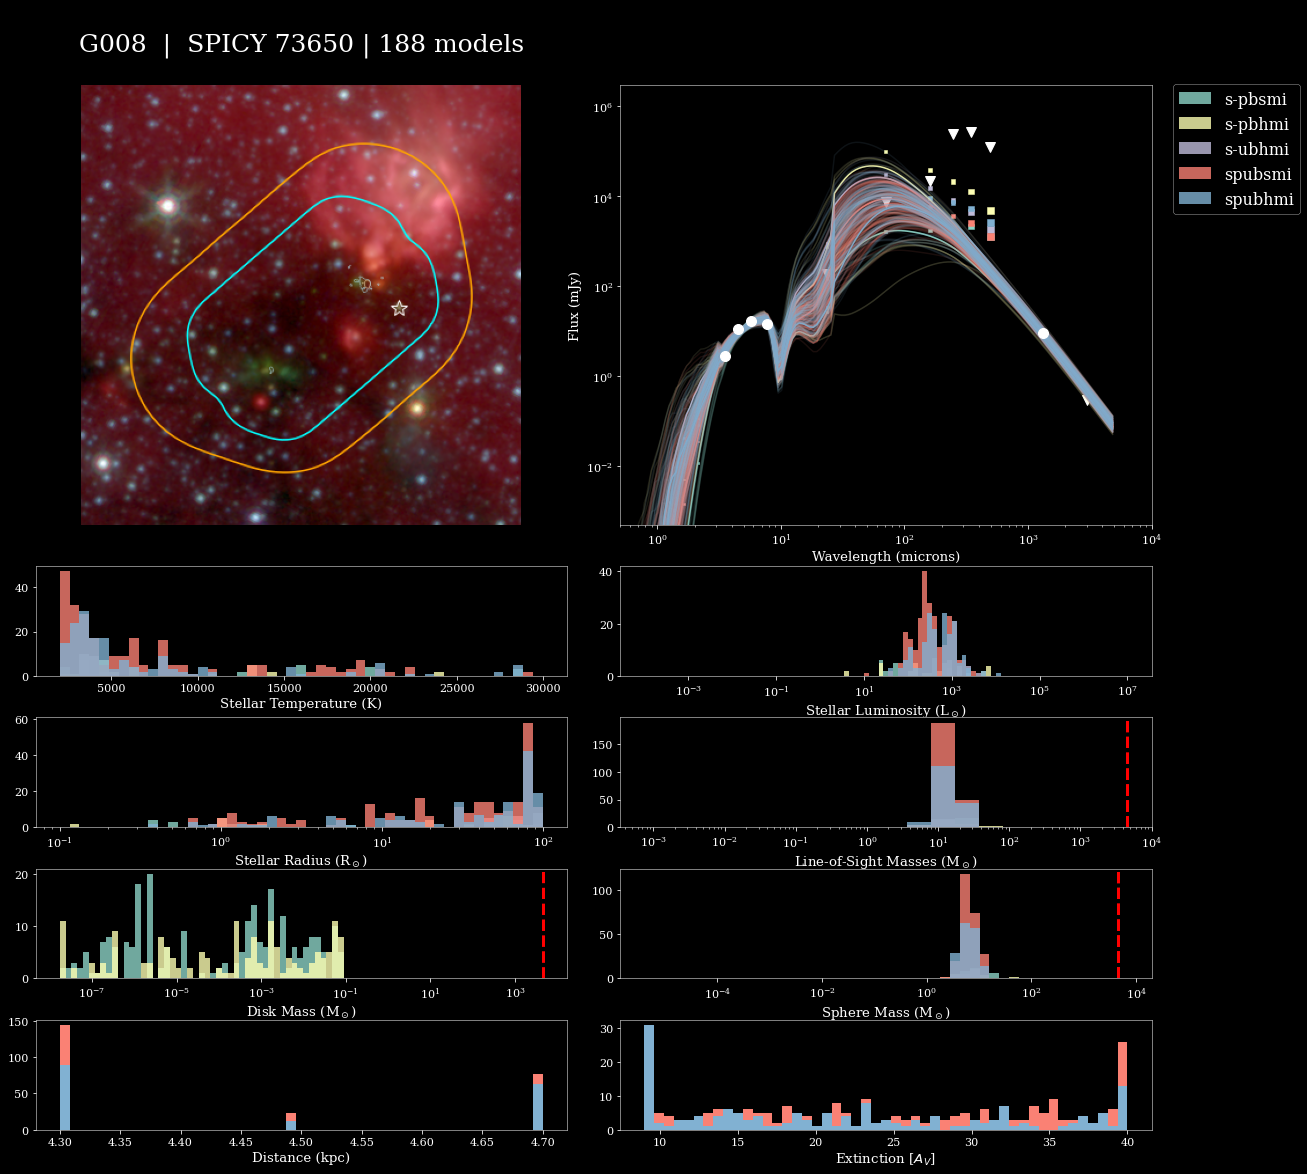

In [15]:
bestfits_source = fitinfo
geometries_selection = geometries_bestfits

import table_loading
import plot_fit
import imp
imp.reload(table_loading)
imp.reload(plot_fit)

from plot_fit import find_mass_ul, datafunction, binsfunction, plot_fit

mass_ul = find_mass_ul(tbl, row_num, regiondistance=4.5)

plot_fit(bestfits_source, geometries_selection, deltachi2limit=chi2limit, mass_ul=mass_ul, fieldid='G008',
             spicyid=SPICYID, modelcount=modelcount, figurepath='/blue/adamginsburg/morganhimes/FieldImages',
             extinction=table_loading.make_extinction(),
             show_per_aperture=True, default_aperture=3*u.arcsec,
             robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/',
             show_all_models=True, alpha_allmodels=0.1, verbose=False,
             min_chi2=None,)

pl.savefig(f'/blue/adamginsburg/morganhimes/SourceTableBuilding/Notebooks/Test/SPICY{SPICYID}.png')

In [16]:
from astropy.stats import mad_std

all_data = []
extinction_data, distance_data = [], []
for geom in geometries:
    pars, data, selection = datafunction(geom, chi2limit, bestfits_source)
    all_data.append(data)
    distance_data.append(10**bestfits_source[geom].sc[selection])
    extinction_data.append(bestfits_source[geom].av[selection])
data = table.vstack(all_data)

extinction_data = np.concatenate(extinction_data)
distance_data = np.concatenate(distance_data)

star_temp_mean = np.nanmean(np.log10(data['star.temperature']))
model_lum_mean = np.nanmean(np.log10(data['Model Luminosity']))
star_rad_mean = np.nanmean(np.log10(data['star.radius']))
los_mass_mean = np.nanmean(np.log10(data['Line-of-Sight Masses'][:,apnum]))
#disk_mass_mean = np.nanmean(np.log10(data['disk.mass']))
sphere_mass_mean = np.nanmean(np.log10(data['Sphere Masses'][:,apnum]))
distance_mean = np.nanmean(np.log10(distance_data))
ext_mean = np.nanmean(np.log10(extinction_data))

star_temp_std = np.nanstd(np.log10(data['star.temperature']))
model_lum_std = np.nanstd(np.log10(data['Model Luminosity']))
star_rad_std = np.nanstd(np.log10(data['star.radius']))
los_mass_std = np.nanstd(np.log10(data['Line-of-Sight Masses'][:,apnum]))
#disk_mass_std = np.nanstd(np.log10(data['disk.mass']))
sphere_mass_std = np.nanstd(np.log10(data['Sphere Masses'][:,apnum]))
distance_std = np.nanstd(np.log10(distance_data))
ext_std = np.nanstd(np.log10(extinction_data))

star_temp_med = np.ma.median(np.log10(data['star.temperature']))
model_lum_med = np.ma.median(np.log10(data['Model Luminosity']))
star_rad_med = np.ma.median(np.log10(data['star.radius']))
los_mass_med = np.ma.median(np.log10(data['Line-of-Sight Masses'][:,apnum]))
#disk_mass_med = np.nanmedian(np.log10(data['disk.mass']))
sphere_mass_med = np.ma.median(np.log10(data['Sphere Masses'][:,apnum]))
distance_med = np.ma.median(np.log10(distance_data))
ext_med = np.ma.median(np.log10(extinction_data))

star_temp_mad = mad_std(np.log10(data['star.temperature']))
model_lum_mad = mad_std(np.log10(data['Model Luminosity']))
star_rad_mad = mad_std(np.log10(data['star.radius']))
los_mass_mad = mad_std(np.log10(data['Line-of-Sight Masses'][:,apnum]))
#disk_mass_mad = mad_std(np.log10(data['disk.mass']))
sphere_mass_mad = mad_std(np.log10(data['Sphere Masses'][:,apnum]))   
distance_mad = mad_std(np.log10(distance_data))
ext_mad = mad_std(np.log10(extinction_data))

PARAMETERS = ['star.temperature', 'Model Luminosity', 'star.radius', 'Line-of-Sight Masses', 'Sphere Masses',
             'distance', 'extinction']
STD = [star_temp_std, model_lum_std, star_rad_std, los_mass_std, sphere_mass_std, distance_std, ext_std]
MEAN = [star_temp_mean, model_lum_mean, star_rad_mean, los_mass_mean, sphere_mass_mean, distance_mean,
       ext_mean]
Median = [star_temp_med, model_lum_med, star_rad_med, los_mass_med, sphere_mass_med, distance_med,
       ext_med]
MAD = [star_temp_mad, model_lum_mad, star_rad_mad, los_mass_mad, sphere_mass_mad, distance_mad,
       ext_mad]

parameter_table = Table([PARAMETERS, MEAN, STD, Median, MAD],
             names=('Parameters', 'Mean', 'Standard Deviation','Median','Median Absolute Deviation'),
             meta={'name': 'SPICY 73642'})

In [17]:
# Note: In order for the table building portion to work, the notebook must have already been run for all
# sources with indices that come before the current source.

from astropy.table import Table, Column, MaskedColumn

if SPICYID == spicy_row_numbers['SPICYID'][0]:
    tbl = Table.read('/blue/adamginsburg/adamginsburg/ALMA_IMF/SPICY_ALMAIMF/SPICY_withAddOns.fits')
else:
    lastSPICYID = spicy_row_numbers['SPICYID'][sourceindex - 1]
    tbl = Table.read(f'SPICY{lastSPICYID}Table.fits')

if 'Temperature mean' not in tbl.colnames:
    tbl['Temperature mean'] = np.nan
if 'Temperature standard deviation' not in tbl.colnames:
    tbl['Temperature standard deviation'] = np.nan
if 'Temperature Median' not in tbl.colnames:
    tbl['Temperature Median'] = np.nan
if 'Temperature MAD' not in tbl.colnames:
    tbl['Temperature MAD'] = np.nan

tbl['Temperature mean'][row_num] = star_temp_mean
tbl['Temperature standard deviation'][row_num] = star_temp_std
tbl['Temperature Median'][row_num] = star_temp_med
tbl['Temperature MAD'][row_num] = star_temp_mad

if 'Luminosity mean' not in tbl.colnames:
    tbl['Luminosity mean'] = np.nan
if 'Luminosity standard deviation' not in tbl.colnames:
    tbl['Luminosity standard deviation'] = np.nan
if 'Luminosity Median' not in tbl.colnames:
    tbl['Luminosity Median'] = np.nan
if 'Luminosity MAD' not in tbl.colnames:
    tbl['Luminosity MAD'] = np.nan

tbl['Luminosity mean'][row_num] = model_lum_mean
tbl['Luminosity standard deviation'][row_num] = model_lum_std
tbl['Luminosity Median'][row_num] = model_lum_med
tbl['Luminosity MAD'][row_num] = model_lum_mad

if 'Radius mean' not in tbl.colnames:
    tbl['Radius mean'] = np.nan
if 'Radius standard deviation' not in tbl.colnames:
    tbl['Radius standard deviation'] = np.nan
if 'Radius Median' not in tbl.colnames:
    tbl['Radius Median'] = np.nan
if 'Radius MAD' not in tbl.colnames:
    tbl['Radius MAD'] = np.nan

tbl['Radius mean'][row_num] = star_rad_mean
tbl['Radius standard deviation'][row_num] = star_rad_std
tbl['Radius Median'][row_num] = star_rad_med
tbl['Radius MAD'][row_num] = star_rad_mad

if 'LOS mass mean' not in tbl.colnames:
    tbl['LOS mass mean'] = np.nan
if 'LOS mass standard deviation' not in tbl.colnames:
    tbl['LOS mass standard deviation'] = np.nan
if 'LOS mass Median' not in tbl.colnames:
    tbl['LOS mass Median'] = np.nan
if 'LOS mass MAD' not in tbl.colnames:
    tbl['LOS mass MAD'] = np.nan

tbl['LOS mass mean'][row_num] = los_mass_mean
tbl['LOS mass standard deviation'][row_num] = los_mass_std
tbl['LOS mass Median'][row_num] = los_mass_med
tbl['LOS mass MAD'][row_num] = los_mass_mad

if 'Sphere mass mean' not in tbl.colnames:
    tbl['Sphere mass mean'] = np.nan
if 'Sphere mass standard deviation' not in tbl.colnames:
    tbl['Sphere mass standard deviation'] = np.nan
if 'Sphere mass Median' not in tbl.colnames:
    tbl['Sphere mass Median'] = np.nan
if 'Sphere mass MAD' not in tbl.colnames:
    tbl['Sphere mass MAD'] = np.nan

tbl['Sphere mass mean'][row_num] = sphere_mass_mean
tbl['Sphere mass standard deviation'][row_num] = sphere_mass_std
tbl['Sphere mass Median'][row_num] = sphere_mass_med
tbl['Sphere mass MAD'][row_num] = sphere_mass_mad

if 'Distance mean' not in tbl.colnames:
    tbl['Distance mean'] = np.nan
if 'Distance standard deviation' not in tbl.colnames:
    tbl['Distance standard deviation'] = np.nan
if 'Distance Median' not in tbl.colnames:
    tbl['Distance Median'] = np.nan
if 'Distance MAD' not in tbl.colnames:
    tbl['Distance MAD'] = np.nan

tbl['Distance mean'][row_num] = distance_mean
tbl['Distance standard deviation'][row_num] = distance_std
tbl['Distance Median'][row_num] = distance_med
tbl['Distance MAD'][row_num] = distance_mad

if 'Extinction mean' not in tbl.colnames:
    tbl['Extinction mean'] = np.nan
if 'Extinction standard deviation' not in tbl.colnames:
    tbl['Extinction standard deviation'] = np.nan
if 'Extinction Median' not in tbl.colnames:
    tbl['Extinction Median'] = np.nan
if 'Extinction MAD' not in tbl.colnames:
    tbl['Extinction MAD'] = np.nan

tbl['Extinction mean'][row_num] = ext_mean
tbl['Extinction standard deviation'][row_num] = ext_std
tbl['Extinction Median'][row_num] = ext_med
tbl['Extinction MAD'][row_num] = ext_mad

if 'Included Geometries' not in tbl.colnames:
    tbl['Included Geometries'] = ",".join(geometries)
    
tbl['Included Geometries'][row_num] = ",".join(geometries_bestfits)

if 'Chi2 threshold' not in tbl.colnames:
    tbl['Chi2 threshold'] = np.nan

tbl['Chi2 threshold'][row_num] = chi2limit

if 'NumberofModels' not in tbl.colnames:
    tbl.Column(name='NumberofModels', format='I')

tbl['NumberOfModels'][row_num] = modelcount

In [18]:
tbl.write(f'SPICY{SPICYID}Table.fits', overwrite=True)

In [19]:
if SPICYID == spicy_row_numbers['SPICYID'][12]:
    tbl.write('SPICYTableG008.fits', overwrite=True)